# Notebook for testing MIRI dithers between APT and OSS #

## 1. Definitions and coordinate reference frames ##

__V2/V3__: A spherical coordinate system measured in arcsec that is tied to the telescope hardware

__Ideal__: Ideal coordinates are a tangent plane projected coordinate system associated with a given SIAF aperture.  The origin of the XIDL, YIDL system is the V2REF, V3REF reference point for that aperture, and this defines the tangent point for the projection.  The rotation between the XIDL, YIDL coordinate system and V2/V3 at this reference point is defined by the angle v3idlyangle (call it $\theta$ for brevity) and the parity P describing the left or right-handedness of the axes.

In the illustration below we show an illustration of the coordinate systems for a notional aperture with $\theta$ = 25 degrees.  We include both parity P=-1 Ideal coordinates (XIDL,YIDL; i.e., what is used by the majority of SIAF apertures), and parity P=+1 Ideal coordinates (XOSS,YOSS; i.e., what is used by the \_OSS SIAF apertures).  We include the relevant equations to transform between OSS left-handed Ideal frame (XOSS/YOSS), APT right-handed ideal frame (XIDL/YIDL), and V2/V3. We also illustrate the offsets corresponding to an example case as interpreted in either the left-handed or right-handed parity.

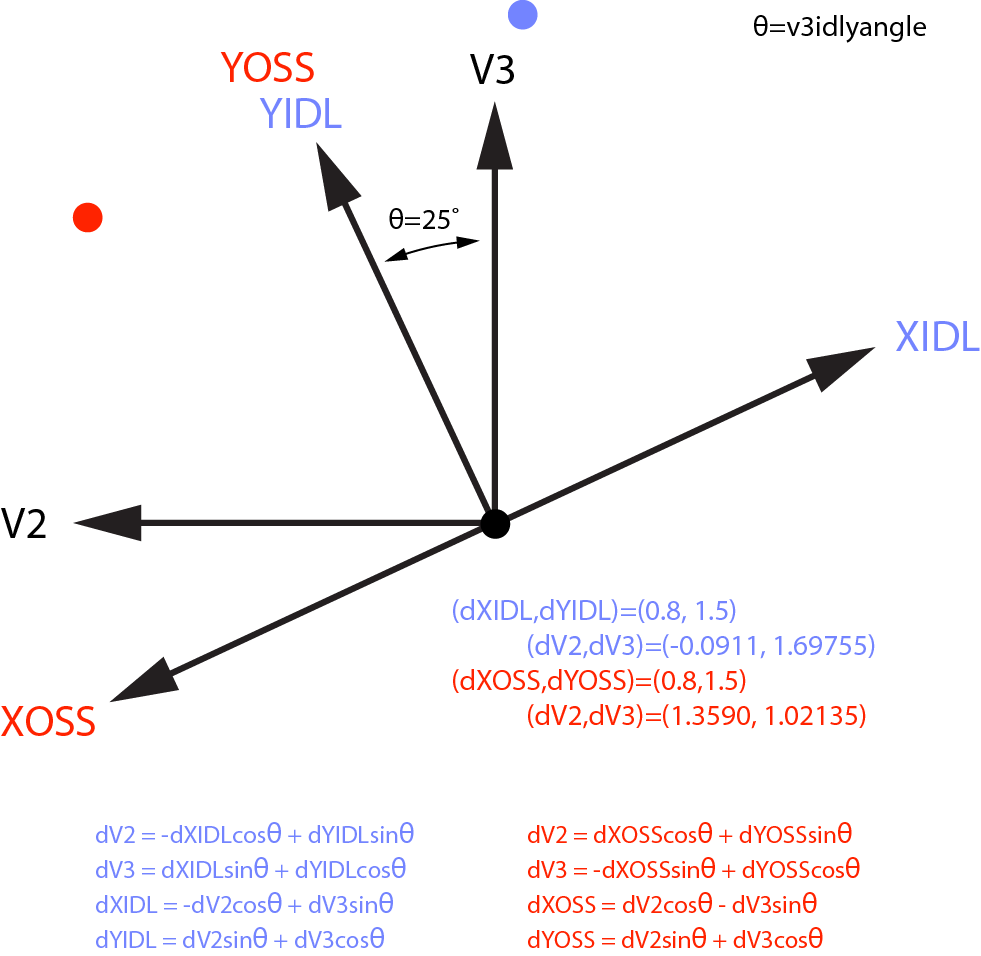

In [1]:
from IPython.core.display import Image 
Image(filename='diagram25deg.png')

Note that intepreting the parity of the Ideal frame dither offset differently does not just flip the sign on the corresponding dv2,dv3 offsets, but fundamentally changes the sense of the offset direction.  In this case, a dither that was intended to be nearly along the V3 direction (blue point) is instead interpreted as a dither than has a substantial component along both V2 and V3 (red point).

The degree to which the V2,V3 frame offsets are scrambled will depend on the rotation angle $\theta$ of the SIAF aperture in use, and the original sense of the desired dithers can ONLY be recovered by using this angle.  As such, simply interpreting parity -1 dithers with a parity +1 aperture in OSS for both the science instruments and the FGS will not result in the correct dithering because the science aperture and the FGS will not generally have the same rotation angle $\theta$.  This means that APT must translate offsets to the OSS Ideal frame, and not to the parity-flipped version of this frame.

Similarly, in some cases the $\theta$ used by the specific APT aperture when interpreting Ideal frame dithers can be different from the v3idlyangle of the aperture that OSS is using to intepret these dithers, which further muddies the situation.

## 2. The MIRI test case ##

In [2]:
import math

In [3]:
from IPython.display import HTML, display

In [4]:
import tabulate

For MIRI, all Ideal coordinate moves should be translated from the actual aperture in use (e.g., MIRIM_ILLUM, MIRIM_SLIT, MIRIFU_CHANNEL1A, etc) to the single parity +1 aperture MIRIM_FULL_OSS.

These examples include one dither (i.e., two positions) for an imaging subarray, LRS slit, and MRS observations.  All of the __equations__ used are identical between the three cases, and only the variables change value.

MIRIM_FULL_OSS has parity +1, and

In [5]:
θOSS=4.449705*math.pi/180.

In [6]:
V2REFOSS=-453.363363

In [7]:
V3REFOSS=-374.068629

## 3. MIRI Imaging Dithers ##

For all MIRI imaging-mode dithers, the v3idlyangle of both the actual aperture and the MIRIM_OSS_FULL aperture is 4.449705 degrees.  We therefore do not have to worry about any changes in v3idlyangle and can concern ourselves only with the effect of the parity.

Let's consider a simple 2-pt dither with the MIRI BRIGHTSKY subarray, which has parity -1 and

In [8]:
θ=4.449705*math.pi/180.

In [9]:
V2REF=-457.194502

In [10]:
V3REF=-396.585948

In the Ideal coordinate frame of the MIRIM_BRIGHTSKY aperture, we have two exposures A and B at

In [11]:
XIDL_A,YIDL_A=-1.650,-3.960

In [12]:
XIDL_B,YIDL_B=1.045,0.550

this corresponds to V2, V3 locations of

In [13]:
V2_A, V3_A=-1*XIDL_A*math.cos(θ)+YIDL_A*math.sin(θ)+V2REF  , XIDL_A*math.sin(θ)+YIDL_A*math.cos(θ)+V3REF

In [14]:
V2_B, V3_B=-1*XIDL_B*math.cos(θ)+YIDL_B*math.sin(θ)+V2REF  , XIDL_B*math.sin(θ)+YIDL_B*math.cos(θ)+V3REF

Now we need to transform this v2/v3 offset to the MIRIM_OSS_FULL ideal reference frame

In [15]:
XOSS_A,YOSS_A=(V2_A-V2REFOSS)*math.cos(θOSS)-(V3_A-V3REFOSS)*math.sin(θOSS) , (V2_A-V2REFOSS)*math.sin(θOSS)+(V3_A-V3REFOSS)*math.cos(θOSS)

In [16]:
XOSS_B,YOSS_B=(V2_B-V2REFOSS)*math.cos(θOSS)-(V3_B-V3REFOSS)*math.sin(θOSS) , (V2_B-V2REFOSS)*math.sin(θOSS)+(V3_B-V3REFOSS)*math.cos(θOSS)

Let's tabulate all of this information for easy reference:

In [17]:
table = [["Aperture","V2","V3","XIDL","YIDL","XOSS","YOSS"],
         ["MIRIM_BRIGHTSKY",round(V2_A,ndigits=3),round(V3_A,ndigits=3),XIDL_A,YIDL_A,round(XOSS_A,ndigits=3),round(YOSS_A,ndigits=3)],
         ["MIRIM_BRIGHTSKY",round(V2_B,ndigits=3),round(V3_B,ndigits=3),XIDL_B,YIDL_B,round(XOSS_B,ndigits=3),round(YOSS_B,ndigits=3)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Aperture,V2,V3,XIDL,YIDL,XOSS,YOSS
MIRIM_BRIGHTSKY,-455.857,-400.662,-1.65,-3.96,-0.423,-26.707
MIRIM_BRIGHTSKY,-458.194,-395.957,1.045,0.55,-3.118,-22.197


Note that the actual VALUES in XOSS and YOSS __are significantly larger__ than in XIDL and YIDL because they are now relative to the zeropoint of a different aperture!

Now let's check that both the IDL and OSS offsets translate to the same actual motion in V2,V3

Call the V2,V3 offsets calculated from IDL coordinates using APT dV2_APT, dV3_APT

In [18]:
dV2_APT = -(XIDL_B-XIDL_A)*math.cos(θ)+(YIDL_B-YIDL_A)*math.sin(θ)

In [19]:
dV3_APT = (XIDL_B-XIDL_A)*math.sin(θ)+(YIDL_B-YIDL_A)*math.cos(θ)

In [20]:
print(round(dV2_APT,ndigits=3),round(dV3_APT,ndigits=3))

-2.337 4.705


And calculate the V2,V3 offsets from OSS coordinates using the OSS logic

In [21]:
dV2_OSS = (XOSS_B-XOSS_A)*math.cos(θOSS)+(YOSS_B-YOSS_A)*math.sin(θOSS)

In [22]:
dV3_OSS = -(XOSS_B-XOSS_A)*math.sin(θOSS)+(YOSS_B-YOSS_A)*math.cos(θOSS)

In [23]:
print(round(dV2_OSS,ndigits=3),round(dV3_OSS,ndigits=3))

-2.337 4.705


They agree, so let's move on to the next case

## 4. MIRI LRS Slit Dithers ##

For all MIRI LRS slit dithers, the v3idlyangle of MIRIM_SLIT is:

In [24]:
θ=4.358324*math.pi/180.

Since this is different from the angle of MIRIM_FULL_OSS, it will be __particularly important__ to take this difference into account

The reference point for the LRS slit is

In [25]:
V2REF=-414.330

In [26]:
V3REF=-400.690

In the Ideal coordinate frame of the MIRIM_SLIT aperture, we have two exposures A and B at

In [27]:
XIDL_A,YIDL_A=-0.908,0.0

In [28]:
XIDL_B,YIDL_B=0.908,0.0

this corresponds to V2, V3 locations of

In [29]:
V2_A, V3_A=-1*XIDL_A*math.cos(θ)+YIDL_A*math.sin(θ)+V2REF  , XIDL_A*math.sin(θ)+YIDL_A*math.cos(θ)+V3REF

In [30]:
V2_B, V3_B=-1*XIDL_B*math.cos(θ)+YIDL_B*math.sin(θ)+V2REF  , XIDL_B*math.sin(θ)+YIDL_B*math.cos(θ)+V3REF

Now we need to transform this v2/v3 offset to the MIRIM_OSS_FULL ideal reference frame

In [31]:
XOSS_A,YOSS_A=(V2_A-V2REFOSS)*math.cos(θOSS)-(V3_A-V3REFOSS)*math.sin(θOSS) , (V2_A-V2REFOSS)*math.sin(θOSS)+(V3_A-V3REFOSS)*math.cos(θOSS)

In [32]:
XOSS_B,YOSS_B=(V2_B-V2REFOSS)*math.cos(θOSS)-(V3_B-V3REFOSS)*math.sin(θOSS) , (V2_B-V2REFOSS)*math.sin(θOSS)+(V3_B-V3REFOSS)*math.cos(θOSS)

Let's tabulate all of this information for easy reference:

In [33]:
table = [["Aperture","V2","V3","XIDL","YIDL","XOSS","YOSS"],
         ["MIRIM_SLIT",round(V2_A,ndigits=3),round(V3_A,ndigits=3),XIDL_A,YIDL_A,round(XOSS_A,ndigits=3),round(YOSS_A,ndigits=3)],
         ["MIRIM_SLIT",round(V2_B,ndigits=3),round(V3_B,ndigits=3),XIDL_B,YIDL_B,round(XOSS_B,ndigits=3),round(YOSS_B,ndigits=3)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Aperture,V2,V3,XIDL,YIDL,XOSS,YOSS
MIRIM_SLIT,-413.425,-400.759,-0.908,0.0,41.889,-23.511
MIRIM_SLIT,-415.235,-400.621,0.908,0.0,40.073,-23.514


Now let's check that both the IDL and OSS offsets translate to the same actual motion in V2,V3

Call the V2,V3 offsets calculated from IDL coordinates using APT dV2_APT, dV3_APT

In [34]:
dV2_APT = -(XIDL_B-XIDL_A)*math.cos(θ)+(YIDL_B-YIDL_A)*math.sin(θ)

In [35]:
dV3_APT = (XIDL_B-XIDL_A)*math.sin(θ)+(YIDL_B-YIDL_A)*math.cos(θ)

In [36]:
print(round(dV2_APT,ndigits=3),round(dV3_APT,ndigits=3))

-1.811 0.138


And calculate the V2,V3 offsets from OSS coordinates using the OSS logic

In [37]:
dV2_OSS = (XOSS_B-XOSS_A)*math.cos(θOSS)+(YOSS_B-YOSS_A)*math.sin(θOSS)

In [38]:
dV3_OSS = -(XOSS_B-XOSS_A)*math.sin(θOSS)+(YOSS_B-YOSS_A)*math.cos(θOSS)

In [39]:
print(round(dV2_OSS,ndigits=3),round(dV3_OSS,ndigits=3))

-1.811 0.138


They agree, so let's move on to the next case

## 5. MIRI MRS Dithers ##

For the MIRI MRS, the field of view of the spectrometer is located about 20 arcsec away from the region in V2/V3 covered by the MIRI imager.  MRS has no OSS versions of its apertures, and even in the SIAF these apertures are defined exclusively as regions of interest with no direct mapping to detector pixels (as the mapping is too complicated).  The Ideal coordinate frame of all MRS apertures (with the exception of MIRIM_TAMRS, which is actually an Imager aperture) is defined to be 

In [40]:
θ=0.*math.pi/180.

Since this is different from the angle of MIRIM_FULL_OSS, it will be __particularly important__ to take this difference into account

The reference point for the MRS dithers changes according to primary channel selected in APT.  However, the same idea applies, so our example will use the case where the aperture is MIRIFU_CHANNEL1A.  The reference point is:

In [41]:
V2REF=-503.654470

In [42]:
V3REF=-318.742460

In the Ideal coordinate frame of the this MRS aperture, we have two exposures A and B at

In [43]:
XIDL_A,YIDL_A=1.139,-0.364

In [44]:
XIDL_B,YIDL_B=-1.028,0.295

this corresponds to V2, V3 locations of

In [45]:
V2_A, V3_A=-1*XIDL_A*math.cos(θ)+YIDL_A*math.sin(θ)+V2REF  , XIDL_A*math.sin(θ)+YIDL_A*math.cos(θ)+V3REF

In [46]:
V2_B, V3_B=-1*XIDL_B*math.cos(θ)+YIDL_B*math.sin(θ)+V2REF  , XIDL_B*math.sin(θ)+YIDL_B*math.cos(θ)+V3REF

Now we need to transform this v2/v3 offset to the MIRIM_OSS_FULL ideal reference frame

In [47]:
XOSS_A,YOSS_A=(V2_A-V2REFOSS)*math.cos(θOSS)-(V3_A-V3REFOSS)*math.sin(θOSS) , (V2_A-V2REFOSS)*math.sin(θOSS)+(V3_A-V3REFOSS)*math.cos(θOSS)

In [48]:
XOSS_B,YOSS_B=(V2_B-V2REFOSS)*math.cos(θOSS)-(V3_B-V3REFOSS)*math.sin(θOSS) , (V2_B-V2REFOSS)*math.sin(θOSS)+(V3_B-V3REFOSS)*math.cos(θOSS)

Let's tabulate all of this information for easy reference:

In [49]:
table = [["Aperture","V2","V3","XIDL","YIDL","XOSS","YOSS"],
         ["MIRIFU_CHANNEL1A",round(V2_A,ndigits=3),round(V3_A,ndigits=3),XIDL_A,YIDL_A,round(XOSS_A,ndigits=3),round(YOSS_A,ndigits=3)],
         ["MIRIFU_CHANNEL1A",round(V2_B,ndigits=3),round(V3_B,ndigits=3),XIDL_B,YIDL_B,round(XOSS_B,ndigits=3),round(YOSS_B,ndigits=3)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Aperture,V2,V3,XIDL,YIDL,XOSS,YOSS
MIRIFU_CHANNEL1A,-504.793,-319.106,1.139,-0.364,-55.539,50.806
MIRIFU_CHANNEL1A,-502.626,-318.447,-1.028,0.295,-53.43,51.631


Note that the actual VALUES in XOSS and YOSS __are significantly larger__ than in XIDL and YIDL because they are now relative to the zeropoint of a different aperture!

Now let's check that both the IDL and OSS offsets translate to the same actual motion in V2,V3

Call the V2,V3 offsets calculated from IDL coordinates using APT dV2_APT, dV3_APT

In [50]:
dV2_APT = -(XIDL_B-XIDL_A)*math.cos(θ)+(YIDL_B-YIDL_A)*math.sin(θ)

In [51]:
dV3_APT = (XIDL_B-XIDL_A)*math.sin(θ)+(YIDL_B-YIDL_A)*math.cos(θ)

In [52]:
print(round(dV2_APT,ndigits=3),round(dV3_APT,ndigits=3))

2.167 0.659


And calculate the V2,V3 offsets from OSS coordinates using the OSS logic

In [53]:
dV2_OSS = (XOSS_B-XOSS_A)*math.cos(θOSS)+(YOSS_B-YOSS_A)*math.sin(θOSS)

In [54]:
dV3_OSS = -(XOSS_B-XOSS_A)*math.sin(θOSS)+(YOSS_B-YOSS_A)*math.cos(θOSS)

In [55]:
print(round(dV2_OSS,ndigits=3),round(dV3_OSS,ndigits=3))

2.167 0.659


They agree!